In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats

path='data_dump/2020_reflectometry.hdf5'
path_other='data_dump/2020_other_signals.hdf5'

f = h5py.File(path, 'a')
f_other=h5py.File(path_other, 'a')

paths=[]
for i in np.arange(2008,2023,1):
    paths.append(str(i))

print(paths)

<frozen importlib._bootstrap>:219: RuntimeWarning: mpi4py.MPI.File size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: mpi4py.MPI.File size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject


['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']


In [7]:
def butter_lowpass_filter(data, cutoff, fs, half_order=5, axis=-1):
    """This function applies a linear digital filter twice, once forward and once backwards. 
    The combined filter has zero phase and a filter order twice that of *half_order*.
    
    Parameters
    ----------
    data: ndarray
        Array of data to filter
    cutoff: float
        Cutoff frequency in Hz.
    fs: float
        Sampling frequency in Hz.
    half_order: int
        Half of the filter order.
    axis: int, optional
        The axis of x to which the filter is applied. Default is -1.
        
    Returns
    -------
    y: ndarray
        Filtered array
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(half_order, normal_cutoff, btype='low', output='sos')
    y = signal.sosfiltfilt(sos, data, axis)
    return y

In [23]:
s=3
keys1=list(f.keys())

# Getting data from path 
t0, t1 = f_other[keys1[s]]['FLAT_TOP']
t_max, n_max = f[keys1[s]]['REF']['rho_poloidal_hfs'].shape
time = np.array(f[keys1[s]]['REF']['time'])
h1 = np.array(f_other[keys1[s]]['DCN']['H-1'])
time_h1 = np.array(f_other[keys1[s]]['DCN']['TIME'])
p_tot = np.array(f_other[keys1[s]]['TOT']['P_TOT'])
time_p_tot = np.array(f_other[keys1[s]]['TOT']['TIME'])
n_hfs = np.array(f[keys1[s]]['REF']['labels'][:,0])
n_lfs = np.array(f[keys1[s]]['REF']['labels'][:,1])
label = np.array(f[keys1[s]]['REF']['labels'][:,2])

#Interpolation of other signals
h1_int=interp1d(time_h1,h1, kind='cubic')
p_tot_int=interp1d(time_p_tot,p_tot, kind='cubic')

# Checking indices for the beginning and end of shot plateau
i_t0, i_t1 = (-1, -1)
for ti in range(t_max):
    if time[ti] >= t0:
        if i_t0 == -1:
            i_t0 = ti
        elif time[ti] <= t1:
            i_t1 = ti+1

# Reassignment for plateau times of reflectometry density measures
print(i_t1,i_t0)
print(time[i_t1],time[i_t0])
t_real = i_t1 - i_t0
time=time[i_t0:i_t1]
h1=h1_int(time)
p_tot=p_tot_int(time)

# Denoising the other signals

fs = 1 / ( time[1] - time[0] )  # Sampling frequency
cutoff = 15                     # Frequency cutoff value in Hz
# h1_filt = np.zeros(t_real)
# p_tot_filt = np.zeros(t_real)

h1_filt = butter_lowpass_filter(h1, cutoff, fs)
p_tot_filt = butter_lowpass_filter(p_tot, cutoff, fs)

# Creating variables for correlation purposes

time_corr=time[n_hfs<2.9*10**19]
n_hfs_corr=n_hfs[n_hfs<2.9*10**19]
n_lfs_corr=n_lfs[n_hfs<2.9*10**19]
h1_corr=h1_filt[n_hfs<2.9*10**19]
p_tot_corr=p_tot_filt[n_hfs<2.9*10**19]
label_corr=label[n_hfs<2.9*10**19]

print(1/fs)

7223 1884
3.7925954 0.9896203
0.0005249977111816406


# Checking correlations with all data

In [9]:
# Checking for correlations

print('Correlations in shot '+ keys1[s] +': \nBetween n_hfs and h1 is:',stats.pearsonr(n_hfs,h1_filt)[0])
print('Between n_hfs and p_tot is:',stats.pearsonr(n_hfs,p_tot_filt)[0])
print('Between n_lfs and h1 is:',stats.pearsonr(n_lfs,h1_filt)[0])
print('Between n_lfs and p_tot is:',stats.pearsonr(n_lfs,p_tot_filt)[0])
print('Between label and h1 is:',stats.pearsonr(label,h1_filt)[0])
print('Between label and p_tot is:',stats.pearsonr(label,p_tot_filt)[0])


Correlations in shot 37020: 
Between n_hfs and h1 is: 0.9640946887567169
Between n_hfs and p_tot is: 0.7929067649490563
Between n_lfs and h1 is: 0.989504135703354
Between n_lfs and p_tot is: 0.8597540606509196
Between label and h1 is: 0.9148050009196269
Between label and p_tot is: 0.7286925386805325


In [19]:
# Plotting results

fig, axs = plt.subplots(3,figsize=(10, 10))
# fig.suptitle('Shot ' + keys1[s] + ' all data', y=0.93, fontsize=16)
axs[0].plot(time,p_tot*10**-6,label='not filtered')
axs[0].plot(time,p_tot_filt*10**-6,label='filtered')
axs[1].plot(time, h1*10**-19,label='not filtered')
axs[1].plot(time,h1_filt*10**-19,label='filtered')
axs[2].plot(time,n_hfs*10**-19,label='HFS')
axs[2].plot(time,n_lfs*10**-19,label='LFS')
axs[0].set(ylabel=r'$P$ $(MW)$')#, title='TOT - P_TOT')
axs[1].set(ylabel=r'$n$ $(10^{19}$ $m^{-3})$')#, title='DCN - H1')
axs[2].set(xlabel='t (s)',ylabel=r'$n$ $(10^{19}$ $m^{-3})$')#, title='Density')
axs[2].legend(title='Density',loc='lower right')
axs[1].legend(title='H-1',loc='lower right')
axs[0].legend(title='P_TOT',)
plt.savefig('Shot_' + keys1[s] + '_other_signals_filtered.png')
plt.show()

In [69]:
# Plotting scatter

fig, axs = plt.subplots(2,figsize=(10, 15))
fig.suptitle('Shot ' + keys1[s] + ' correlation data', y=0.93, fontsize=16)
axs[0].scatter( h1_filt[::5]*10**-19, n_hfs[::5]*10**-19, alpha=0.5, label='HFS')
axs[0].scatter( h1_filt[::5]*10**-19, n_lfs[::5]*10**-19, alpha=0.5,label='LFS')
axs[1].scatter( p_tot_filt[::5]*10**-6, n_hfs[::5]*10**-19, alpha=0.5, label='HFS')
axs[1].scatter( p_tot_filt[::5]*10**-6, n_lfs[::5]*10**-19, alpha=0.5, label='LFS')
axs[0].set(xlabel=r'$h1$ $(10^{19}$ $m^{-3})$', ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title=r'$n_{h}$ vs H1' )
axs[1].set(xlabel=r'$P$ $(MW)$', ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title=r'$n_{h}$ vs P_TOT' )
axs[0].set_ylim(0,None)
axs[0].set_xlim(0,None)
axs[1].set_ylim(0,None)
axs[1].set_xlim(0,None)
axs[0].legend()
axs[1].legend()
plt.savefig('Shot_' + keys1[s] + '_scatter.pdf')
plt.show()

# Checking correlation outside plateau

In [25]:
# Checking for correlations out of 3*10**19 hfs plateau

print('Correlations in shot '+ keys1[s] +': \nBetween n_hfs and h1 is:',stats.pearsonr(n_hfs_corr,h1_corr)[0])
print('Between n_hfs and h1_corr is:',stats.pearsonr(n_hfs_corr,p_tot_corr)[0])
print('Between n_lfs_corr and h1 is:',stats.pearsonr(n_lfs_corr,h1_corr)[0])
print('Between n_lfs and p_tot is:',stats.pearsonr(n_lfs_corr,p_tot_corr)[0])
print('Between label and h1 is:',stats.pearsonr(label_corr,h1_corr)[0])
print('Between label and p_tot is:',stats.pearsonr(label_corr,p_tot_corr)[0])

Correlations in shot 37020: 
Between n_hfs and h1 is: 0.9749379390845425
Between n_hfs and h1_corr is: 0.4322794520903717
Between n_lfs_corr and h1 is: 0.9277985787995794
Between n_lfs and p_tot is: 0.5668786934427383
Between label and h1 is: 0.9286308873275847
Between label and p_tot is: 0.34974293350889213


In [21]:
# Plotting results

fig, axs = plt.subplots(3,figsize=(10, 10))
fig.suptitle('Shot ' + keys1[s] + ' correlation data', y=0.93, fontsize=16)
axs[0].plot(time_corr,p_tot_corr*10**-6)
axs[1].plot(time_corr,h1_corr*10**-19)
axs[2].plot(time_corr,n_hfs_corr*10**-19,label='HFS')
axs[2].plot(time_corr,n_lfs_corr*10**-19,label='LFS')
axs[0].set(ylabel=r'$P$ $(MW)$', title='TOT - P_TOT')
axs[1].set(ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title='DCN - H1')
axs[2].set(xlabel='t (s)',ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title='Density')
axs[2].legend()
#plt.savefig('Shot_' + keys1[s] + '_other_signals_filtered.pdf')
plt.show()

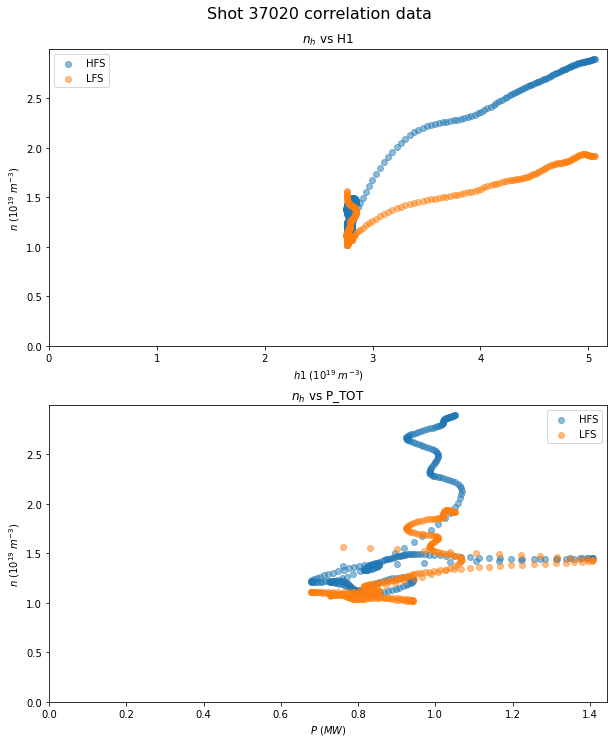

In [22]:
# Plotting scatter

fig, axs = plt.subplots(2,figsize=(10, 12))
fig.suptitle('Shot ' + keys1[s] + ' correlation data', y=0.93, fontsize=16)
axs[0].scatter( h1_corr[::5]*10**-19, n_hfs_corr[::5]*10**-19, alpha=0.5, label='HFS')
axs[0].scatter( h1_corr[::5]*10**-19, n_lfs_corr[::5]*10**-19, alpha=0.5,label='LFS')
axs[1].scatter( p_tot_corr[::5]*10**-6, n_hfs_corr[::5]*10**-19, alpha=0.5, label='HFS')
axs[1].scatter( p_tot_corr[::5]*10**-6, n_lfs_corr[::5]*10**-19, alpha=0.5, label='LFS')
axs[0].set(xlabel=r'$h1$ $(10^{19}$ $m^{-3})$', ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title=r'$n_{h}$ vs H1' )
axs[1].set(xlabel=r'$P$ $(MW)$', ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title=r'$n_{h}$ vs P_TOT' )
axs[0].set_ylim(0,None)
axs[0].set_xlim(0,None)
axs[1].set_ylim(0,None)
axs[1].set_xlim(0,None)
axs[0].legend()
axs[1].legend()
plt.savefig('Shot_' + keys1[s] + '_scatter.pdf')
plt.show()

In [30]:
df_model = pd.DataFrame(index=time, columns=['n_h','n_l'])
df_model['n_h']=f[keys1[s]]['REF']['labels'][:,0]
df_model['n_l']=f[keys1[s]]['REF']['labels'][:,1]
df_model['n_front']=f[keys1[s]]['REF']['labels'][:,2]
print(time.shape,h1.shape,p_tot.shape)

(6920,) (6920,) (6920,)


In [71]:
f.close()
f_other.close()

In [7]:

keys1=list(f.keys())
for key in keys1:
    # Getting data from path 
    t0, t1 = f_other[key]['FLAT_TOP']
    t_max, n_max = f[key]['REF']['rho_poloidal_hfs'].shape
    time = np.array(f[key]['REF']['time'])
    h1 = np.array(f_other[key]['DCN']['H-1'])
    time_h1 = np.array(f_other[key]['DCN']['TIME'])
    p_tot = np.array(f_other[key]['TOT']['P_TOT'])
    time_p_tot = np.array(f_other[key]['TOT']['TIME'])
    n_hfs = np.array(f[key]['REF']['labels'][:,0])
    n_lfs = np.array(f[key]['REF']['labels'][:,1])

    #Interpolation of other signals
    h1_int=interp1d(time_h1,h1, kind='cubic')
    p_tot_int=interp1d(time_p_tot,p_tot, kind='cubic')

    # Checking indices for the beginning and end of shot plateau
    i_t0, i_t1 = (-1, -1)
    for ti in range(t_max):
        if time[ti] >= t0:
            if i_t0 == -1:
                i_t0 = ti
            elif time[ti] <= t1:
                i_t1 = ti+1

    # Reassignment for plateau times of reflectometry density measures
    t_real = i_t1 - i_t0
    time=time[i_t0:i_t1]
    h1=h1_int(time)
    p_tot=p_tot_int(time)

    # Denoising the other signals

    fs = 1 / ( time[1] - time[0] )  # Sampling frequency
    cutoff = 15                     # Frequency cutoff value in Hz
    h1_filt = np.zeros(t_real)
    p_tot_filt = np.zeros(t_real)

    h1_filt = butter_lowpass_filter(h1, cutoff, fs)
    p_tot_filt = butter_lowpass_filter(p_tot, cutoff, fs)

    # Creating variables for correlation purposes

    time_corr=time[n_hfs<2.9*10**19]
    n_hfs_corr=n_hfs[n_hfs<2.9*10**19]
    n_lfs_corr=n_lfs[n_hfs<2.9*10**19]
    h1_corr=h1_filt[n_hfs<2.9*10**19]
    p_tot_corr=p_tot_filt[n_hfs<2.9*10**19]

    # Checking for correlations

    # print('Correlations in shot '+ key +': \nBetween n_hfs and h1 is:',stats.pearsonr(n_hfs,h1_filt)[0])
    # print('Between n_hfs and p_tot is:',stats.pearsonr(n_hfs,p_tot_filt)[0])
    # print('Between n_lfs and h1 is:',stats.pearsonr(n_lfs,h1_filt)[0])
    # print('Between n_lfs and p_tot is:',stats.pearsonr(n_lfs,p_tot_filt)[0])
    with open("Output.txt", "a") as text_file:
        print('\nCorrelations in shot '+ key +': \nBetween n_hfs and h1 is:',stats.pearsonr(n_hfs,h1_filt)[0] ,file=text_file)
        print('Between n_hfs and p_tot :',stats.pearsonr(n_hfs,p_tot_filt)[0],file=text_file)
        print('Between n_lfs and h1 is:',stats.pearsonr(n_lfs,h1_filt)[0],file=text_file)
        print('Between n_lfs and p_tot :', stats.pearsonr(n_lfs,p_tot_filt)[0] ,file=text_file)
        print('Correlations in shot '+ key + ' outside plateau : \nBetween n_hfs and h1_corr is:',stats.pearsonr(n_hfs_corr,h1_corr)[0],file=text_file)
        print('Between n_hfs and p_tot_corr is:',stats.pearsonr(n_hfs_corr,p_tot_corr)[0],file=text_file)
        print('Between n_lfs_corr and h1 is:',stats.pearsonr(n_lfs_corr,h1_corr)[0],file=text_file)
        print('Between n_lfs and p_tot is:',stats.pearsonr(n_lfs_corr,p_tot_corr)[0],file=text_file)

